In [2]:
# I recommend you leave this on True when grading, it disables the 
# back-translation data augmentation and does a single training loop 
# instead of a hyper-parameter search.

# Feel free to switch it to False to test all the features but be warned that
# execution can take upwards of two hours.

# Also don't forget to upload all the CSV files included in the repo to 
# your Colab environment!

is_grader = True

# Installs & Imports

In [3]:
!pip install sentencepiece transformers datasets numpy pandas ray[tune] hyperopt ray pickle5==0.0.10 nlpaug

In [14]:
import ray
import pandas as pd
import os
import math
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import nltk
import nlpaug
import nlpaug.augmenter.word as naw
from datasets import load_dataset, load_metric, Dataset, DatasetDict, load_from_disk
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments, EarlyStoppingCallback, set_seed)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from ray import tune

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Exploration

In [5]:
# Grab these three files from the repo and upload them to your Colab session

train_ids = set(pd.read_csv('train_ids.csv').par_id.values)
val_ids = set(pd.read_csv('dev_ids.csv').par_id.values)

# Load the dataset
df = pd.read_csv('dontpatronizeme_pcl.tsv', sep='\t')

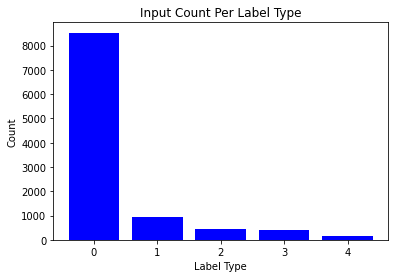

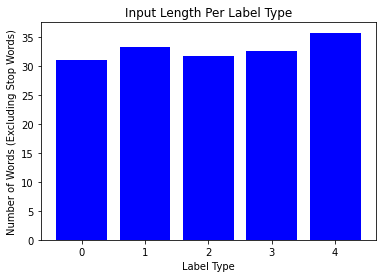

In [6]:
df["text"] = df.text.apply(str)

# Remove stopwords from the text and compute number of words
stop_words = set(stopwords.words('english'))
def f(x):
    words = word_tokenize(x)
    final_tokens = []
    for each in words:
        if each not in stop_words:
            final_tokens.append(each)
    return len(final_tokens)

df["input_len"] = df.text.apply(f)

# Generate plot for label counts
label_counts = df.label.value_counts().to_numpy()

x = list(range(5))
y = label_counts

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='blue')
plt.xlabel("Label Type")
plt.ylabel("Count")
plt.title("Input Count Per Label Type")

plt.xticks(x_pos, x)

plt.show()

# Generate plot for input length
input_lengths = df.groupby('label')['input_len'].mean()

y = input_lengths

plt.bar(x_pos, y, color='blue')
plt.xlabel("Label Type")
plt.ylabel("Number of Words (Excluding Stop Words)")
plt.title("Input Length Per Label Type")

plt.xticks(x_pos, x)

plt.show()


# Data Preprocessing & Augmentation

In [7]:
# Load a fresh copy of the dataset
df = pd.read_csv('dontpatronizeme_pcl.tsv', sep='\t')

# Make sure there is text
df = df[df['text'].notna()]
# Bin the labels
df["labels"] = df.label.apply(lambda x: 0 if x == 0 or x == 1 else 1)

# Clean-up the text by removing text that brings no meaningful information
df["text"] = df.text.apply(lambda t: t.replace("<h>", ""))
remove = ["-- AFP", "/AFP /", "/AFP", "PHOTO AFP", "/ AFP PHOTO /", 
          "AFP PHOTO", "( AFP )", "-AFP", "PHOTO : AFP", "AFP/", "( Photo : AFP/SAM YEH )", "AFP Photo", 
          "PHOTO SIA KAMBOU AFP  In Summary", "PHOTO : China Daily/Asia News Network", 
          "( SUPPLIED PHOTO )", "PHOTO ABDIMALIK HAJIR NATION MEDIA GROUP  In Summary", 
          "PHOTO : REUTERS .", "- PHOTO BY CARL GILCHRIST", "PHOTO : SUPPLIED",
          "PHOTO : CHOO CHWEE HUA", "PHOTO : astrid februarie",
          "XINHUA PHOTO - ZHAI JIANLAN", "PHOTO : REUTERS", "Photograph : Alkis Konstantinidis/Reuters",
          "Photograph : Darko Vojinovic/AP", "( Photo : Ron Batzdorff/NBC/NBCU Photo Bank via Getty Images )", 
          "Image : AP Photo", "Photo : AP/Matt Dunham", "Photo : Prabir Das", 
          "Photo : Getty Images", "( Photo : News18 )", "( AP Photo/Emilio Morenatti )", 
          "( AP Photo/Claudia Torrens )", 'Photo : mostafigur rahman', 
          "( AP Photo/Matt Dunham )", "Photograph : Hassan Ammar/AP", "( AP )", 
          "( Photo : Omar Fungo )", "( AP Photo/MANILA BULLETIN )", "Photo- Creative Commons",
          "Photo : AP", "( AP Photo/Jerome Delay , File/ MANILA BULLETIN )",
          "( Photo : Getty )", "File photograph : iStockPhoto", "( Photos : SOSD )",
          "( AP Photo/Min Kyi Thein )", "Photo/Sportpicha  In Summary", "Photo:Frank Aman",
          "AP Photo/Themba Hadebe", "Photo/un.org", "( AP Photo/Firdia Lisnawati/ MANILA BULLETIN )",
          "( File Photo/REUTERS )", "( AP Photo/Mosa'ab Elshamy )", " ( Photo : Khalfan Said )",
          "( Photo by Peti Siyame )", "Photo : Boipelo Mere", "Photo : STARHossain Seraj , Magura",
          "( AP Photo/Kathy Willens , File ) Comments", "Photo : asif mahmud ove", "( Photos by Staff Photographer )",
          "( Photo : SAM YEH )", "( Photo : Alan Chin for Yahoo News )", "( Photo by Selin Thomas )", "Source : AAP",
          "( Source : YouTube ) "]
for r in remove:
  df["text"] = df.text.apply(lambda t: t.replace(r, ""))

df["text"] = df.text.apply(lambda t: t.lower())

In [8]:
# Split dataset into train, val and test
df_train = df[df.par_id.isin(train_ids)][["text", "labels"]]
df_val = df[df.par_id.isin(val_ids)][["text", "labels"]]
df_test = pd.read_csv('test_set.tsv', sep='\t')[["text"]]


# Contextual word embedding augmentation. This will insert new words into the
# samples by feeding the surrounding words into BERT and inserting the word that
# is closest to the surrounding words in BERT's latent space.
aug1 = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert", device="cuda")
aug2 = naw.SynonymAug(aug_src='wordnet')

if not is_grader:
  aug3 = naw.BackTranslationAug(device="cuda")
  aug4 = naw.RandomWordAug(action="swap")

augs = []
augs += list(df_train[df_train.labels==1].text.apply(lambda t: aug1.augment(t, n=2)))
augs += list(df_train[df_train.labels==1].text.apply(lambda t: aug2.augment(t, n=2)))

# The back-translation augmentation can take upwards of 
# an hour to run, even on a P100 GPU
if not is_grader:
  augs += list(df_train[df_train.labels==1].text.apply(lambda t: aug3.augment(t, n=2)))
  augs += list(df_train[df_train.labels==1].text.apply(lambda t: aug4.augment(t, n=2)))

df_train_augmented = df_train.append([{"text": aug, "labels": 1} for aug in augs])
df_train_augmented = df_train_augmented.explode("text")

# We can skip this data checkpoint when grading
if not is_grader:
  df_train.to_csv("df_train.csv")
  df_train_augmented.to_csv("df_train_augmented.csv")

if is_grader:
  N = 3900
else:
  N = 7000
  
# Construct a perfectly balanced dataset by sampling from the negative samples
# and the positive samples (augmented)
df_train_augmented = pd.concat([df_train_augmented[df_train_augmented.labels==0].sample(N), 
                                df_train_augmented[df_train_augmented.labels==1].sample(N)])

In [9]:
def generate_tokenized_data(model_name, train, val, test):
  tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)

  def tokenize_function(sample):
      return tokenizer(sample["text"], padding="max_length", truncation=True)

  train_data = Dataset.from_pandas(train[["text", "labels"]], preserve_index=False)
  val_data = Dataset.from_pandas(val[["text", "labels"]], preserve_index=False)
  test_data = Dataset.from_pandas(test[["text"]], preserve_index=False)

  dd = DatasetDict({"train": train_data, "val": val_data, "test": test_data})

  dd = dd.map(tokenize_function, batched=True)

  return dd

# Modelling

In [24]:
model_name = "roberta-base"

dd = generate_tokenized_data(model_name, df_train_augmented, df_val, df_test)


set_seed(38)
early_stopping_patience = 5

def get_model():
    return AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )

training_args = TrainingArguments(
        output_dir=".",
        learning_rate=2e-5,  # overriden by hparam search
        do_train=True,
        do_eval=True,
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=50,
        save_steps=50,
        num_train_epochs=10,  # early stopping
        save_total_limit=early_stopping_patience,
        load_best_model_at_end=True,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        gradient_accumulation_steps=1,
        metric_for_best_model = 'f1',
        warmup_steps=385,  # overriden by hparam search
        weight_decay=0.3,  # overriden by hparam search
        logging_dir="./logs",
        skip_memory_metrics=True,
        report_to="none")

metric = load_metric("f1")
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
        model_init=get_model,
        args=training_args,
        train_dataset=dd["train"],
        eval_dataset=dd["val"],
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)])

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cach

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

PyTorch: setting up devices
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Some weights of the model chec

In [25]:
if is_grader:
  trainer.train()
else:
  # Initialise ray for hyper-param search
  ray.shutdown()
  ray.init(log_to_driver=True, ignore_reinit_error=True)

  scheduler = tune.schedulers.PopulationBasedTraining(
      mode = "max",
      metric='eval_f1',
      perturbation_interval=2,
      hyperparam_mutations={
          "weight_decay": tune.uniform(0.0, 0.3),
          "learning_rate": tune.uniform(1e-5, 5e-5),
          "warmup_steps": tune.randint(0, 500)
      }
  )

  best_trial = trainer.hyperparameter_search(
      direction="maximize",
      backend="ray",
      n_trials=10,
      keep_checkpoints_num=1,
      scheduler=scheduler)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Some weights of the model checkpoint at roberta-base were 

Step,Training Loss,Validation Loss,F1
50,No log,0.728824,0.173647
100,No log,0.348282,0.025751
150,No log,0.288231,0.367688
200,No log,0.271347,0.518349
250,No log,0.242382,0.457143
300,No log,0.220164,0.392283
350,No log,0.251415,0.539615
400,No log,0.282248,0.519231
450,No log,0.254903,0.486486
500,0.297800,0.283131,0.550000


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 32
Saving model checkpoint to ./checkpoint-50
Configuration saved in ./checkpoint-50/config.json
Deleting older checkpoint [checkpoint-200] due to args.save_total_limit
Deleting older checkpoint [checkpoint-400] due to args.save_total_limit
Deleting older checkpoint [checkpoint-600] due to args.save_total_limit
Deleting older checkpoint [checkpoint-800] due to args.save_total_limit
Deleting older checkpoint [checkpoint-1000] due to args.save_total_limit
Deleting older checkpoint [checkpoint-1200] due to args.save_total_limit
Deleting older checkpoint [checkpoint-1400] due to args.save_total_limit
Deleting older checkpoint [checkpoint-100] due to args.save_tot